In [40]:
import pandas as pd
import numpy as np
import datetime
import glob
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


### Read data:

In [41]:
path = r'/home/hai-feng/Documents/dohaWeather'
all_files = glob.glob(path + "/*.csv")


df = pd.concat((pd.read_csv(f) for f in all_files))

### Drop null data, convert time to datatime stamp format:

In [42]:
df = df[["Converted time", "temp"]]
df = df.dropna(how='any')
df = df[~df.isin(["null","NaN"]).any(axis=1)]

df["Converted time"] = pd.to_datetime(df["Converted time"])
df.sort_values("Converted time", inplace=True)
df.shape[0]

247325

### Fill all missing hours with its former data:

In [43]:
# First drop duplex of time coloumn
df = df.drop_duplicates(subset='Converted time')
# set "converted time" column to be index
df.index = df["Converted time"]
# Resample based on "H" hour, fill in back value, then cancel the index(reset it)
df=df.resample("H").backfill().reset_index(drop = True)

df.shape[0]

202689

### Decomposite base on day period, get the trend of day:

<Figure size 432x288 with 0 Axes>

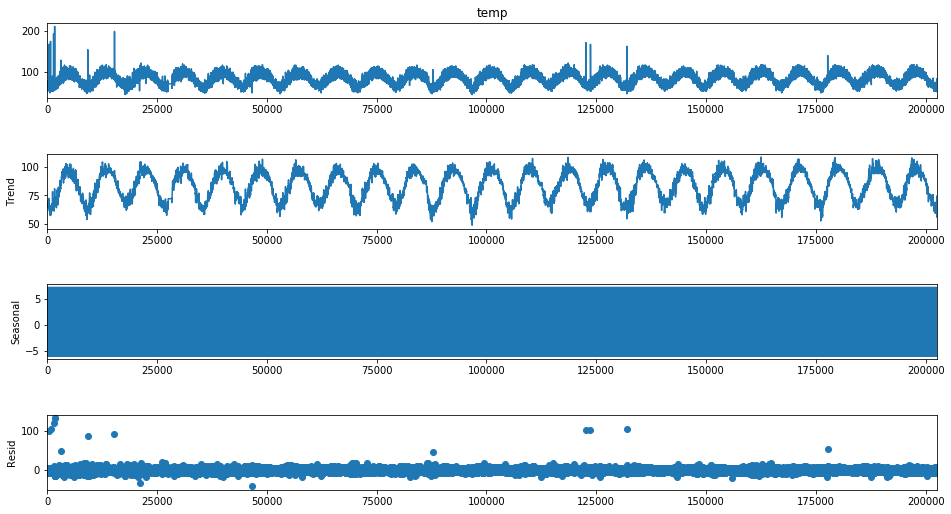

In [44]:
decomposition = seasonal_decompose(df.temp, freq=24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [45]:
daily_season = decomposition.seasonal
daily_trend = decomposition.trend
daily_resid = decomposition.resid

### Decomposite base on year period, get the trend of year:

<Figure size 432x288 with 0 Axes>

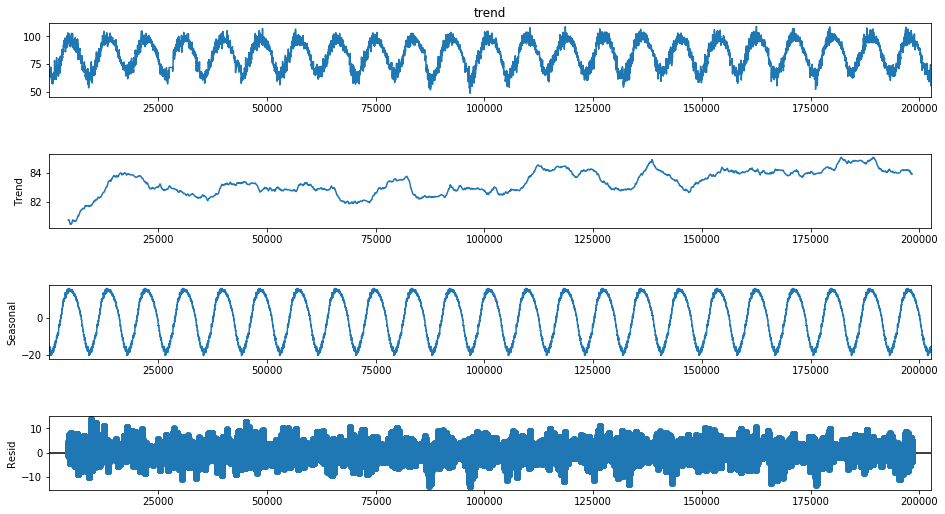

In [48]:
decomposition = seasonal_decompose(daily_trend.dropna(), freq=8760)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

> From above, we have decomposited the trend of the year, it doesn't have daily, yearly dependencies. It only
rely on the global climate, we say the data points are indenpedent.
Therefore we are going to use regression to predict the trend of the future 10 years.

#### Change temperature data from float 64 to float 32, saving memory:

In [50]:
df['temp'] = df['temp'].astype(np.float32)
df = df.rename(columns={'Converted time':"ds", "temp":"y"})

### To do the prediction, we will use fbprophet tool. It decomposites seasonal component and do linear regression for us automatically:

In [8]:
from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

- We set weekly_seasonality to false, since temperature only has daily and yearly seasonality.
- Since we are going to use all history trend to do linear regression, we set n_changepoints=0. Prophet is useing pieces regression, n_changepoints=0 means model treat all history data as a whole.

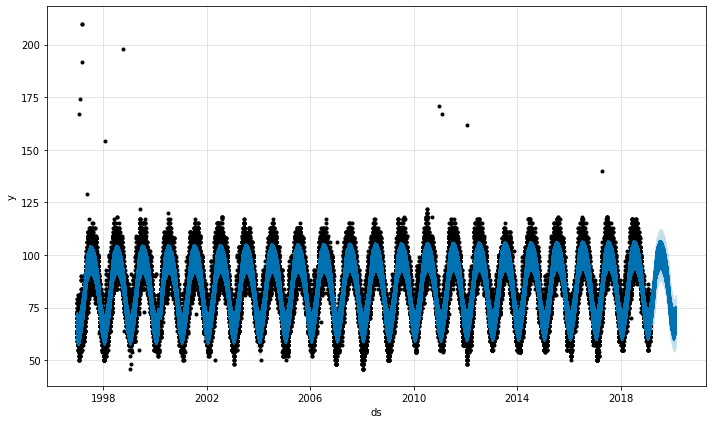

In [53]:
m = Prophet(changepoint_prior_scale=0.1,weekly_seasonality=False,n_changepoints=0).fit(df.iloc[0:-8760])
future = m.make_future_dataframe(periods=8760, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

**Above is our prediction, we are predict the last 8760 hours' temperature(blue curve), that means from 2019-02-15 5:00 to 2020-02-15 05:00:00.**

Next we calculate the RMSE error:

In [57]:
def getRMSE(series1, series2):
    return np.sqrt(np.mean((series1-series2)**2))

In [65]:
getRMSE(fcst.iloc[-8760:].yhat, df.iloc[-8760:].y)

4.273693600154502

We see the RMSE is quite low, only around 4.27.

### Now we predict the following 10 years' hourly temperature.

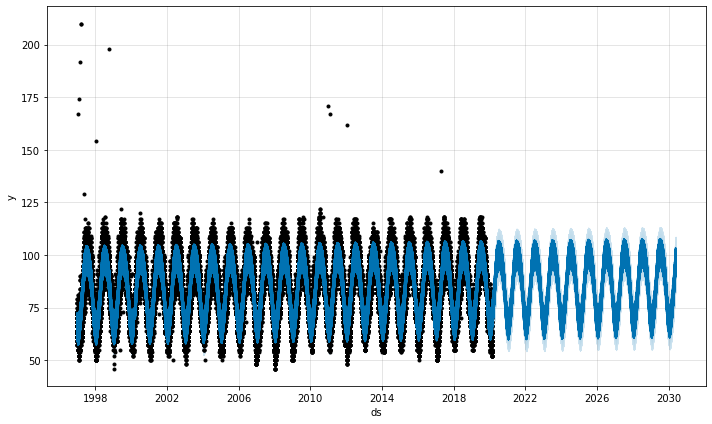

In [70]:
m = Prophet(changepoint_prior_scale=0.1,weekly_seasonality=False,n_changepoints=0).fit(df)
future = m.make_future_dataframe(periods=90000, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

### Check the components of our prediction:

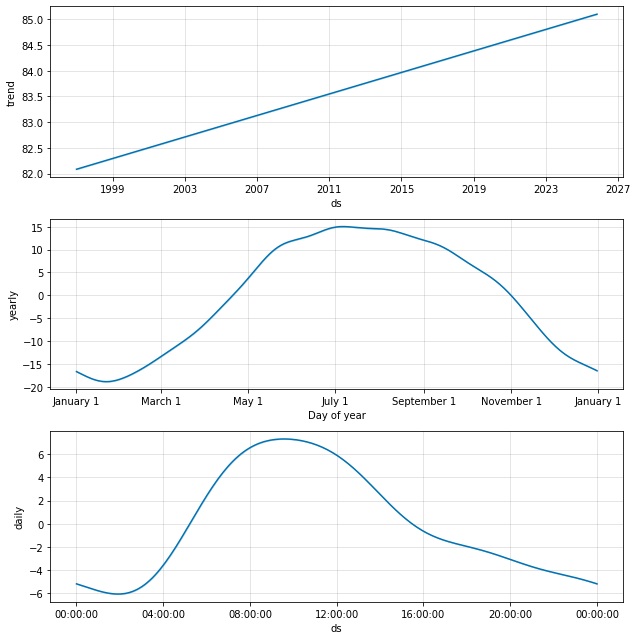

In [33]:
fig = m.plot_components(fcst)

From above we see:
- The trend is linear regression.
- Yearly and daily seasonality.

This is the average temperature of our whole fitted data and prediction:

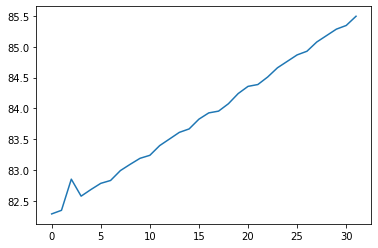

In [94]:
averages = []
xtick=[]
for i in range(1998,2030):
    average = fcst[fcst["ds"].dt.year == i].yhat.mean()
    averages.append(average)
    xtick.append(i)
plt.plot(averages)

Export prediction to csv:

In [96]:
fcst.iloc[-90000:].to_csv('/home/hai-feng/Documents/dohaWeather/prediction.csv', index=False)